In [289]:
import numpy as np 
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import f_oneway
import pandas as pd
import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [290]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [300]:
# 데이터 불러오기
past_sales = pd.read_csv('C:/Users/rlaeo/OneDrive/바탕 화면/rossmann.csv')
store = pd.read_csv('C:/Users/rlaeo/OneDrive/바탕 화면/store.csv')

# 데이터 제거
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)

# 데이터 병합
data = pd.merge(left = past_sales,right = store, on = 'Store', how = 'right')

# 날짜
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
data['Year']=pd.DatetimeIndex(data.Date).year
data['Month']=pd.DatetimeIndex(data.Date).month
data['Day']=pd.DatetimeIndex(data.Date).day
data = data.drop(['Date'],axis=1)

# 데이터 가공 : StateHoliday, Open
data['StateHoliday'] = data['StateHoliday'].replace({0:'d'}) # 0 값은 d로 대체
data['StateHoliday'] = data['StateHoliday'].replace({'0':'d'})# 0 값은 d로 대체
open = data[data['Open']==0].index
data.drop(open,inplace=True)


# 결측값 처리
data = data.dropna(axis=0)

# store,open 이름 제거
data = data.drop(['Open'],axis=1)

# 데이터 분리(수치형, 범주형)
digital_cols = ['Sales', 'Customers', 'CompetitionDistance', 'Year','Month', 'Day']
digital_data = data[digital_cols]
digital_data = pd.DataFrame(digital_data.values, columns = digital_cols)
digital_data
# 표준화
scaler = MinMaxScaler().fit(digital_data)
digital_data = pd.DataFrame(scaler.transform(digital_data),index = digital_data.index, columns = digital_cols)

categorey_clos = data.columns.drop(digital_cols)
categorey_data = data[categorey_clos]
categorey_data = pd.DataFrame(categorey_data.values, columns = categorey_clos)

# 인코딩
onehotencoding_cols = ['StateHoliday', 'StoreType', 'Assortment', 'DayOfWeek']
categorey_data = pd.get_dummies(data=categorey_data, columns=onehotencoding_cols)


# 데이터 병합
data = pd.concat([digital_data, categorey_data], axis = 1)

# 형 통일
data = data.astype({'Promo2':'int', 'StateHoliday_b':'int', 'StateHoliday_c':'int', 'StateHoliday_d':'int', 'StoreType_a':'int', 'StoreType_b':'int', 'StoreType_c':'int', 'StoreType_d':'int'})
data = data.astype({'Assortment_a':'int', 'Assortment_b':'int', 'Assortment_c':'int', 'DayOfWeek_1':'int', 'DayOfWeek_2':'int', 'DayOfWeek_3':'int', 'DayOfWeek_4':'int', 'DayOfWeek_5':'int', 'DayOfWeek_6':'int', 'DayOfWeek_7':'int'})

pd.options.display.max_columns = None
data['StateHoliday_a'] = data['StateHoliday_a'].replace({True: 1, False: 0})
data

C:\Users\rlaeo\AppData\Local\Temp\ipykernel_21416\1998093515.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  past_sales = pd.read_csv('C:/Users/rlaeo/OneDrive/바탕 화면/rossmann.csv')


KeyError: "Only a column name can be used for the key in a dtype mappings argument. 'StateHoliday_b' not found in columns."

In [292]:
data = data.groupby('Store').get_group(610)
data

,Sales,Customers,CompetitionDistance,Year,Month,Day,Store,Promo,SchoolHoliday,Promo2,StateHoliday_a,StateHoliday_b,StateHoliday_c,StateHoliday_d,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
461024,0.101297,0.070790,0.008439,1.0,0.545455,1.000000,610,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0
461025,0.101754,0.063617,0.008439,1.0,0.545455,0.966667,610,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0
461026,0.107458,0.071332,0.008439,1.0,0.545455,0.933333,610,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0
461027,0.116892,0.078370,0.008439,1.0,0.545455,0.900000,610,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0
461028,0.146711,0.080130,0.008439,1.0,0.545455,0.866667,610,1,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461798,0.188251,0.112209,0.008439,0.0,0.000000,0.200000,610,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0
461799,0.072345,0.052924,0.008439,0.0,0.000000,0.133333,610,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0
461800,0.089914,0.069437,0.008439,0.0,0.000000,0.100000,610,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0
461801,0.079517,0.061316,0.008439,0.0,0.000000,0.066667,610,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0


In [293]:
target_col = 'Sales'
features_cols = data.columns.drop(target_col)        
features = data[features_cols]
target = data[target_col]
target = pd.DataFrame(target.values.reshape(-1,1))
features = features.values
target = target.values

In [294]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=True)
print('train_data의 row : %s, column : %s'%(x_train.shape[0],x_train.shape[1]))
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

train_data의 row : 623, column : 27


In [295]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256,input_dim = 27,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam',
             loss='mse',
             metrics=['mean_absolute_error'])

In [298]:
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=64,
                    epochs=50,
)

Epoch 1/50
10/10 [==============================] - 0s 12ms/step - loss: 0.0121 - mean_absolute_error: 0.0884 - val_loss: 0.0021 - val_mean_absolute_error: 0.0414
Epoch 2/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0102 - mean_absolute_error: 0.0802 - val_loss: 0.0020 - val_mean_absolute_error: 0.0399
Epoch 3/50
10/10 [==============================] - 0s 8ms/step - loss: 0.0093 - mean_absolute_error: 0.0785 - val_loss: 0.0019 - val_mean_absolute_error: 0.0392
Epoch 4/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0086 - mean_absolute_error: 0.0742 - val_loss: 0.0022 - val_mean_absolute_error: 0.0420
Epoch 5/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0081 - mean_absolute_error: 0.0713 - val_loss: 0.0022 - val_mean_absolute_error: 0.0425
Epoch 6/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0070 - mean_absolute_error: 0.0672 - val_loss: 0.0022 - val_mean_absolute_error: 0.0418
Epoch 7/50
10/10 [=========

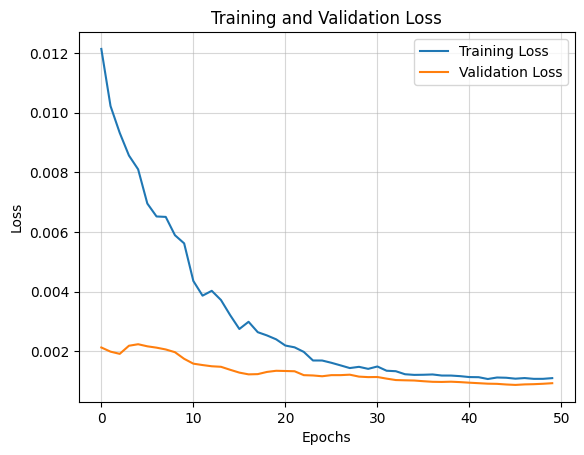

5/5 [==============================] - 0s 3ms/step - loss: 9.2755e-04 - mean_absolute_error: 0.0257

 Test Accuracy: 0.0257


In [299]:
import matplotlib.pyplot as plt
# 손실 그래프
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 그리드 추가
plt.grid(True, linestyle='-', alpha=0.5)

plt.show()
print("\n Test Accuracy: %.4f" %(model.evaluate(x_test,y_test)[1]))